In [ ]:
#@title Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Part 1: Load/Analyze Data

##What is your dataset? Please describe your dataset and where you got it

My dataset is from https://github.com/bananathrowingmachine/FastPartitionExperimentDocs/tree/main/Previous%20Results/Full%20Runs which is some saved data generated from a personal project a wrote in May, which I made just to see if I could make a really fast algorith that solves the psuedo-polynomial time partition problem, at least compared to the solution found on Wikipedia (which I did infact beat quite well). The data essentially has 3 x variables and a y variable, where the x variables are the algorithm type (with there being 4 types, the Wikipedia solution, one change I made, another change I made, and then both changes combined together), the amount of integers in the set, and the approximate sum of the set and then the y variable is the average amount of iterations each method took to solve the same randomly(-ish) generated set. For more information on how the experiment was run as a whole you can look here: https://github.com/bananathrowingmachine/FastPartitionExperiment

For this project the data is just linked directly to where it's stored on GitHub with the argument raw=true so that it doesn't redirect to the human visiable page.

How I convert the data is I will turn every combination of inputs and results into a single long list, where the first variable will denote if the data comes from a Memoized algorithm (signified as 1) or a Tabulated algorithm (signified as 0), the second variable will denote if the date comes from a "Crazy" algorithm (signified as 1, with the main GitHub repo elaborating on what "Crazy" means), or a "Normal" algorithm (signified as 0), the third variable will be the "Sum Target" (also elaborated on in the main GitHub repository) and the fourth variable will be the integer count.

Due to my data being available publicly on my Github, the direct links to the sheets already in the code are sufficient for accessing the necessary data frames and vstack them all into a numpy array.

##Load your dataset / Implement your dataloader

In [ ]:
def processSheet(fileName: str):
    sheet = pd.ExcelFile(fileName)
    processedData = []
    for sheetName in sheet.sheet_names:
        if sheetName not in ['Recursive Normal', 'Absolute Target Sum']:
            df = pd.read_excel(sheet, sheet_name=sheetName)
            dfReset = df.reset_index().rename(columns={'index': 'Row_Index'})
            dfLong = dfReset.melt(id_vars=['Row_Index'], var_name='Col_Index', value_name='Value')
            dfCleaned = dfLong[dfLong['Col_Index'] != 'Unnamed: 0'].copy()
            dfCleaned['Col_Index'] = pd.to_numeric(dfCleaned['Col_Index']).astype(int)

            rows = dfCleaned.values.shape[0]
            crazyVals = np.ones((rows, 1)) if 'Crazy' in sheetName else np.zeros((rows, 1))
            memoVals = np.ones((rows, 1)) if 'Memoized' in sheetName else np.zeros((rows, 1))
            processedData.append(np.hstack((memoVals, crazyVals, dfCleaned)))

    return np.vstack(processedData)

# Links to the excel sheets directly on my GitHub so I don't have to upload them to Colab.
# These files are public so the data will be converted into a dataframe automatically when this cell is run
sheet1 = 'https://github.com/bananathrowingmachine/FastPartitionExperimentDocs/blob/main/Previous%20Results/Full%20Runs/May%2026%2C%202025/data_tables/Results.xlsx?raw=true'
sheet2 = 'https://github.com/bananathrowingmachine/FastPartitionExperimentDocs/blob/main/Previous%20Results/Full%20Runs/Jul%2012%2C%202025/data_tables/Results.xlsx?raw=true'
run1 = processSheet(sheet1)
run2 = processSheet(sheet2)
numpyDataArray = np.vstack([run1, run2])
x_train, x_combine, y_train, y_combine = train_test_split(numpyDataArray[:, 0:4], numpyDataArray[:, 4], test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_combine, y_combine, test_size=0.5, random_state=42)

##Dataset Analyis Statistics

**Overall:**

The high level explanation of this data set is that it is a "full factorial design with replication". For this case specifically, it means that every combination of features is found exactly twice in the data as a whole. This means that not only that every combination of inputs is accounted for, but especially in the train sets there is a way to account for the variability that comes with my data as there will definitely be quite a few duplicates. Below is some code to generate very basic statistics on the feature sets.

In [ ]:
print('Dataset Partition Sizes:')
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}\n')

print('Example rows:')
print('Memoized Flag | Crazy Flag | Sum Target Index | Integer Count')
print(x_train[0:5])
print('Average iterations:')
print(f'{y_train[0:5]}\n')

print('General Statistics:')
fullLength = x_train.shape[0] + x_val.shape[0] + x_test.shape[0]
print(f'Each value of the \'Memoized\' feature has {fullLength/2} occurances.')
print(f'Each value of the \'Crazy\' feature has {fullLength/2} occurances.')
print(f'Each value of the \'Sum Target Index\' feature has {fullLength/21} occurances.')
print(f'Each value of the \'Integer Count\' feature has {fullLength/20} occurances.')
print(f'With a total of {fullLength} rows, that means there are {int(fullLength/2)} unqiue combinations.\n')

print('Target Variable Statistics:')
print(f'Mean: {np.mean(numpyDataArray[:, 4])}')
print(f'Min: {np.min(numpyDataArray[:, 4])}')
print(f'Man: {np.max(numpyDataArray[:, 4])}')
print(f'Std Dev: {np.std(numpyDataArray[:, 4])}')
print(f'Replicate 1 Mean: {np.mean(run1[:, 4])}')
print(f'Replicate 1 Std Dev: {np.std(run1[:, 4])}')

Dataset Partition Sizes:
x_train shape: (2352, 4)
y_train shape: (2352,)
x_val shape: (504, 4)
y_val shape: (504,)
x_test shape: (504, 4)
y_test shape: (504,)

Example rows:
Memoized Flag | Crazy Flag | Sum Target Index | Integer Count
[[  0.   1.  15.  90.]
 [  0.   0.   0.  40.]
 [  1.   0.  15.  95.]
 [  1.   1.  19.  80.]
 [  0.   0.   8. 100.]]
Average iterations:
[9.94945914e+07 3.99281600e+05 4.73466736e+07 1.52217400e+04
 1.31108548e+08]

General Statistics:
Each value of the 'Memoized' feature has 1680.0 occurances.
Each value of the 'Crazy' feature has 1680.0 occurances.
Each value of the 'Sum Target Index' feature has 160.0 occurances.
Each value of the 'Integer Count' feature has 168.0 occurances.
With a total of 3360 rows, that means there are 1680 unqiue combinations.

Target Variable Statistics:
Mean: 22913060.490648806
Min: 6.4
Man: 325035152.0
Std Dev: 45591355.45382001
Replicate 1 Mean: 22910780.969214287
Replicate 1 Std Dev: 45591158.67678241


**Graphs:**

Below are some graphs generated by my intial run of the project that created this data back in May. Each graph represnts a different set of the first 2 features, and displays how the last 2 features modify the output. With these graphs it shows that all 4 of the features do effect each other in odd ways, with a easy example being how much better the crazy version for the memoized algorithms are compared to the tabulated graphs, and also how much more unpredictable the memoized graphs are. Additionally, while matplotlib doesn't show it too well, the memoized versions take significantly longer amounts of time on odd integer counts than even ones, and the overall growth of the integer count is a lot more exponential. One thing that makes my data especially interesting in my opinion is how the "Memoized Crazy" algorithm has extremely high variance compared to others, which is also why I the graphs for that algorithm both times I ran the full experiment. For the other algorithms the variation is rather small.

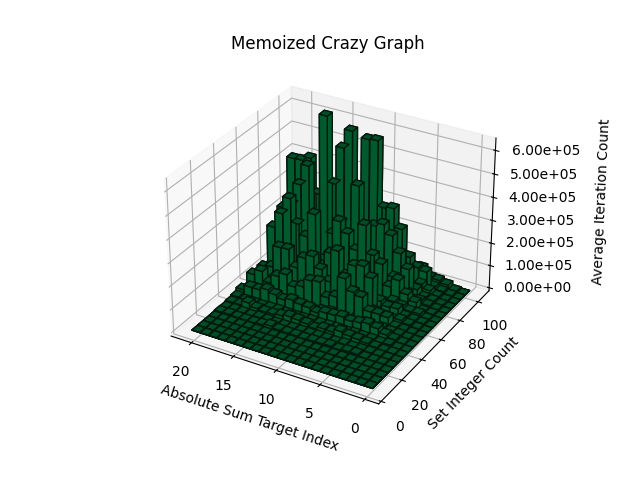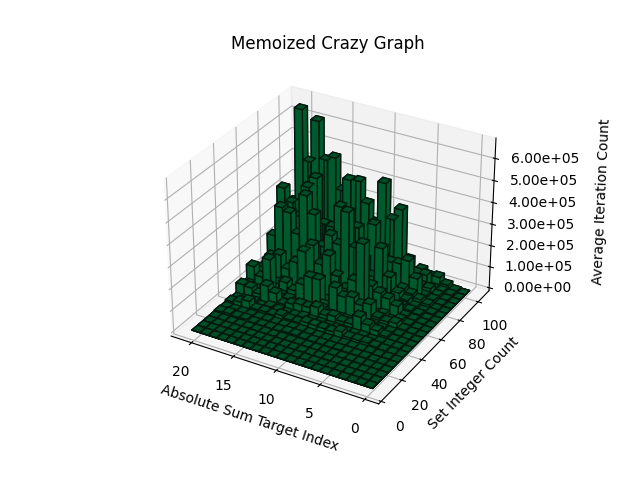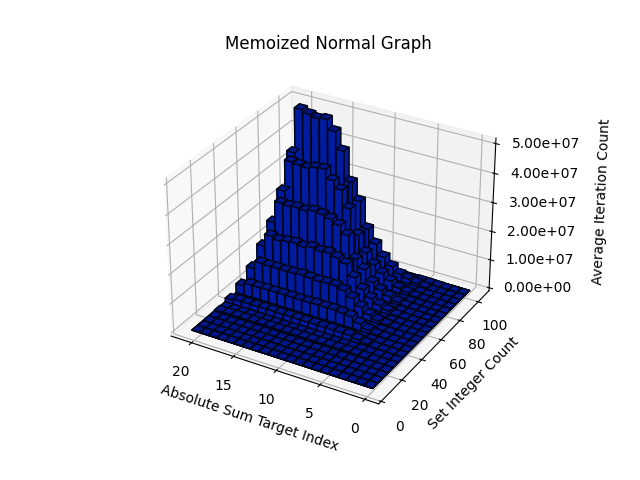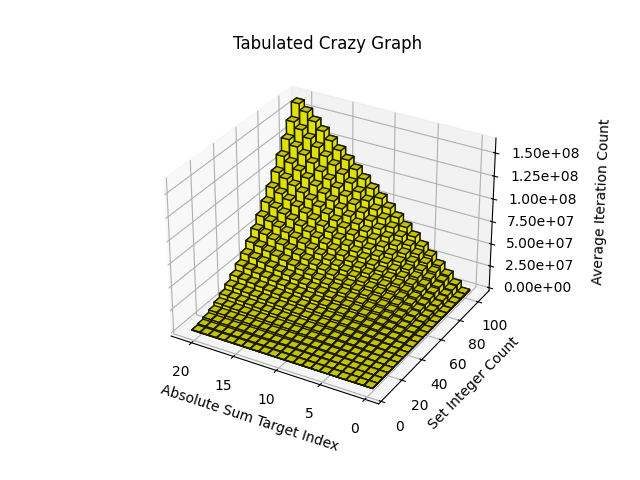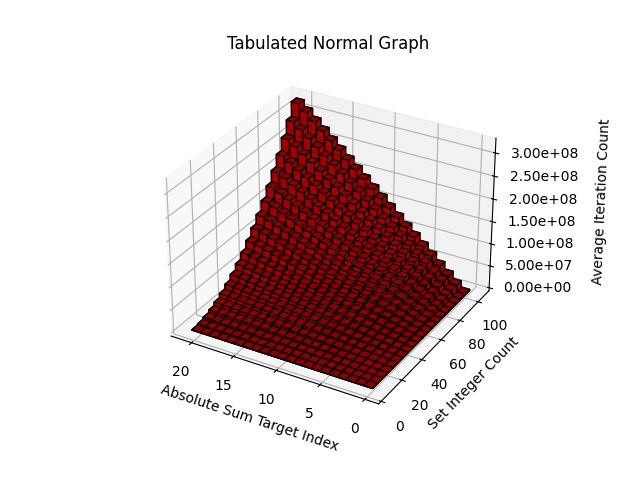

# Part 2: Literature Review

While my dataset has never been experimented on, overall it's a decently simple idea so I looked for papers regarding Neural Networks that were given full factorial data to train on.

[The first one](https://github.com/bananathrowingmachine/UniProj-OpenEndedDeepLearning/blob/main/SMPracticeThoery2004.pdf) is:
Alam, F. M., McNaught, K. R., & Ringrose, T. J. (2004). A comparison of experimental designs in the development of a neural network simulation metamodel. *Simulation Modelling Practice and Theory*, 12(7-8), 559–578. https://doi.org/10.1016/j.simpat.2003.10.006 and is an old study about what experiment designs are best used to train Neural Networks. While more focused on the experiment design itself, I can still get valuable insights into what they used as their Neural Network. Overall the methodology for this paper was to obtain simulated Input-Output data, develop empirical ANN Metamodels, then use it for predicition. Since the methodology is more focused on generating different experiment designs there isn't too much for me here, however it does note that the fully factorial design is actually not the best for Neural Networks which is very interesting. What's far more helpful for me in this study is their Network layout, which was a MLP with 5 nodes in the hidden layer, which was what preformed best, and that's additionally notable as this experiment used 4 features just like mine, and then trained with backpropogation.

[The second one](https://github.com/bananathrowingmachine/UniProj-OpenEndedDeepLearning/blob/main/Multilayer_perceptron_and_neural_network.pdf) is: Popescu, M. C., Balas, V. E., Perescu-Popescu, L., & Mastorakis, N. (2009). Multilayer perceptron and neural networks. *WSEAS Transactions on Circuits and Systems*, 8(7), 579-588. This paper is a lot more about a standard MLP implementation, with some helpful details on how exactly to create a MLP. It's methodology is rather simple, where it compares how a fuzzy controller and nueral controller solve the same problem of induction driving, where it is trained on the control surface of the existing fuzzy controller. The implementation the paper came up with is 4-layer, feed forward, and uses sigmoid functions because they are non-linear and differenciable.

# Part 3: Implement networks in PyTorch

Note of warning here: Depending on how easily you can allocate GPU resources, you may want to make your network much shallower so that you can train it more easily
Aim to have one gradient update take no more than a few seconds
May also want to reduce the number of training steps if training is too slow

In [ ]:
# TODO - implement your PyTorch Module

In [ ]:
# TODO - implement your training loop

In [ ]:
# TODO - plot train and validation accuracy of your model during training

Hint: look at earlier homeworks / resuse code from those to help you here

# Part 4: Run Hyperparameter Experiments

In [ ]:
# TODO - perform hyperparameter grid searches and plot accuracies

In [ ]:
# TODO - perform other experiments and plot accuracies

In [ ]:
# TODO - calculate the final test accuracy

TODO - Explain your experiments above. See assignment doc for more details.